<a href="https://colab.research.google.com/github/AinaRB/DailyTemperature_RandomForest_SaoPaulo/blob/main/RFTemp_Pipeline_April2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Random Forest (RF) for predicting daily mean temperature at 500 x 500m resolution over Sao Paulo between 2015 and 2019**

note: Adapted from Pipeline_Feb2023.ipynb

This code is writen to be run as a Google Collab Notebook with the input data stored in your local drive.

The code, will automatically find your current directory and allow you to define a 'desired directory'. In section 1.2. we define the needed folders and create them if they don't exist.
For the code to run smoothly you will need the following file and folder:

```
'modelinput_2015_2019.csv'
.../newdata/...
```
You can download them from Github repository:
https://github.com/AinaRB/DailyTemperature_RandomForest_SaoPaulo/tree/main



# **1. Set up environment**

## 1.1. Upload packages

In [ ]:
# DOWNLOAD PACKAGES
#!pip install mlxtend
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib

In [ ]:
# LOAD PACKAGES REQUIRED TO RUN TO CODE
# General packages
import numpy as np
import pandas as pd
from glob import glob
from time import time
import io
import missingno as msno
import random
import datetime as dt

# ML regression packages
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SequentialFeatureSelector

# Deep learning packages
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, Dense, ReLU, Dropout, Activation, Concatenate, Reshape, MaxPooling3D, Conv1D, Conv2D, Conv3D, Bidirectional, BatchNormalization, Flatten, Input, GRU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K

# Plotting packages
import seaborn as sns
from plotnine.data import diamonds
import matplotlib.pyplot as plt

# Feature selection packages
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.neighbors import KNeighborsClassifier
from mlxtend.data import iris_data
from sklearn.model_selection import GroupKFold
from sklearn import metrics

# For random forest
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import RandomizedSearchCV

# Other utilities
from datetime import datetime
import os
import warnings
import pickle
from pprint import pprint


## 1.2. Define folder structure

The code, will automatically find your current directory and allow you to define a 'desired directory'.

It will also define the needed folders and create them if they don't exist. For the code to run smoothly you will need to download the following file and folder:

```
'modelinput_2015_2019.csv'  -> upload inside your rcently created 'Data' folder
.../newdata/...  -> upload all contents in your recently created 'Newdata' folder
```
You can download them from Github repository:
https://github.com/AinaRB/DailyTemperature_RandomForest_SaoPaulo/tree/main



In [ ]:
# MOUNT GDRIVE TO COLAB
from google.colab import drive
drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# DEFINE WORKING DIRECTORIES
# Get the current working directory
current_directory = os.getcwd()
print("Current working directory:", current_directory)

# Desired directory [!] Change this to your desired directory [!]
desired_directory ="/content/gdrive/MyDrive/Colab Notebooks/RFTemp_Pipeline_Public" # [!] change this to your desired directory

# If the retrieved directory does not match your desired directory, please change using ..
if current_directory != desired_directory:
    os.chdir(desired_directory)
    print("Directory changed to:", desired_directory)
else:
    print("Directory is already set to the desired directory.")

In [ ]:
# CREATE FOLDERS FOR FIGURES AND TABLES
# List of directories to check and create if they don't exist
## Figures = to save plots generated
## Tables = to save tables generated
## Data = to save any intermediate dataset generated worth keeping
## Newdata = will contain the daily excel files with the predictor variables for all grids to predict  [!] Make sure to upload those from Github [!]
## Predictions = to save the files containing the temperature predictions
directories = ['Figures', 'Tables', 'Data', 'Predictions', 'Newdata']

# Check and create directories
for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)
        print(f"Directory '{directory}' created successfully.")
    else:
        print(f"Directory '{directory}' already exists.")



## 1.3. Load data

In [ ]:
# UPLOAD DATA FOR MODEL TRAINING
df_original=pd.read_csv(os.path.join('Data/modelinput_original/modelinput_2015_2019.csv')) #The data was generated by the file '01_DataPreparation.ipynb'
df_original.info()## 87648 entries; 37 columns

In [ ]:
#TRANSFORM STATIONS NAMES TO STRINGS
df_original['station_co'] = df_original['station_co'].astype(str)

In [ ]:
#KEEP ONLY VARIABLES OF INTEREST
#Define variables to keep
vars= ['station_co','cluster','date', 'temp_mean75','day', 'month', 'year','bsa', 'sza', 'lst', 'popdens', 'water', 'ndvi', 'slope', 'dem', 'impsurf', 't2m', 'd2m',  'landcov','artland', 'lake', 'b200m', 'b400m', 'coast','daylength','doy','lat','lon','v10','u10', 'sp','rh', 'skt']

#Apply selection
df_original=df_original[vars]

#Explore df dimensions
df_original.shape # 87648 entries; 33 columns

## 1.4. Define parameters for code

In [ ]:
##[DELETE?]

#Define ML alortihm we will be runing
algorithm='RF'

# 2.Data preparation


## 2.1. Missing values

Here we will use the [*missingno* package (*msno*)](https://pypi.org/project/missingno/) to visualy investigate the pattern of missingness in the dataset. We will use the *matrix plot* to identify which and where are the missing values for each variable. Heatmaps shows the correlation of missingness between every 2 columns. In our dataset, since only one variable (temperature) had missing values, this plot is not feasible.

In [ ]:
# DEFINE DATASETS TO USE (df_hp; hyperparameter tunning; or df_original, for model fitting)
df=df_original
using_df='original' #stores informaion on df currently in use
df.info()

In [ ]:
#MATRIX PLOT OF NAs (colors https://www.tug.org/pracjourn/2007-4/walden/color.pdf)
fig=msno.matrix(df.drop(['station_co', 'date', 'cluster' ,'day', 'month', 'year'], axis=1), sparkline=False, figsize=(15,8), fontsize=12, color=(0.3,0.5,0.6))
fig_copy = fig.get_figure()
fig_copy.savefig(os.path.join('Figures/missing_barplot2_'+using_df+'.png'), bbox_inches = "tight")

We confirm that the only variable wtih missing data is *temp_mean75*. This is what we expect as we imputed all the predictor variables prior to this step. We will not impute the ground truth to avoid introducing bias the model. Instead, we will exclude observations with missing values. Note, that this will also affect the validation dataset, which will have some gaps visible when we plot the time series of the validation.

Below the expected stats:
*   Dimensions of original dataset:  (87648, 33)
*   Dimensions of dataset after removing NAs:  (78569, 33)
*   Data loss:  10 %

In [ ]:
# DROP ALL NAs FROM DF
df_c=df.dropna()
#df.info()
print('Dimensions of original dataset: ', df.shape)
print('Dimensions of dataset after removing NAs: ', df_c.shape)
print('Data loss: ', round(100-(df_c.shape[0]/df.shape[0]*100)), '%')

In [ ]:
# EXPORT DATASET WITHOUT NAs
df_c.to_csv(os.path.join('Data/modelinput_2015_2019_noNA.csv'))

## 2.2.Creating Training and external validation datasets
External validation involves the use of a hold-out dataset to investigate the model's ability to generalize across unseen locations and time. This is particularly interesting to ensure the model is generalizable within the prediction domain and to mitigate the risk of overfitting to dataset peculiarities, offering a more reliable evaluation of a model's real-world performance. n our case, the model trains on a network of data points with (mostly) complete daily temperature information over the study period, and it is expected to generate predictions at unseen locations for the same temporal window. So, we used a **hold-out dataset comprising 10% of all available stations (n=5 stations; 6,799 observations)**, reserved from the outset and never seen during model training. The selection of station was done randomly to mimick the reality. By NOT selecting stations that are necessarily good representation of the training dataset, we avoid favouring the model performance. The rest (i.e. not external validation dataset), will become our training dataset

*NOTE: We use random.seed(30) to ensure reporducibility - i.e., the same random selection applied if the code is run multiple times.*

In [ ]:
# RANDOM STATION SELECTION FOR EXTERNAL VALIDATION
## Create station list
stations = df_c['station_co'].unique(); stations

##Select 4 stations randomly
random.seed(30)
sample=random.sample(list(stations), 5)
print("Stations for external validation:", ", ".join(sample))

## Exclude these stations from training
dfExtVal=df_c[df_c['station_co'].isin(sample)]
dftrain=df_c[~df_c['station_co'].isin(sample)]

##Export dataset
dftrain.to_csv(os.path.join('Data/modelinputTrain.csv'))#Export dataset
dfExtVal.to_csv(os.path.join('Data/modelinputExtVal.csv'))#Export dataset



---



In [ ]:
#SUMMARY STATISTICS OF TRAINING AND EXT VAL DATASETS
print('Train stations: ', len(dftrain['station_co'].unique()))
print('ExtVal stations: ', len(dfExtVal['station_co'].unique()))

print('Train obs: ', len(dftrain['station_co']))
print('ExtVal obs: ', len(dfExtVal['station_co']))

In [ ]:
#DATA CHECKS
#Plot distribution of temperature (target variable)

#Calculate t-test for differences
from scipy.stats import ttest_ind
stat, p_value = ttest_ind(dfExtVal['temp_mean75'], dftrain['temp_mean75'])
print(f"t-test: statistic={stat:.3f}, p-value={p_value:.3f}")

#colors https://i.stack.imgur.com/nCk6u.jpg
font={'size': 16,'weight': 'normal'} #dictonary for fonts
print("Original (blue) and HP datasets (orange)")
fig, ax = plt.subplots(figsize=(10,8))
ax = dftrain['temp_mean75'].hist(bins=40, color="#31668a") #original dataset (color=ugly blue )
dfExtVal['temp_mean75'].hist(bins=40, color="#cb9d06") # HP dataset (color= yellow ochre)
plt.text(6, 5100, f"t-test: statistic={stat:.2f}, p-value={p_value:.3f}", fontdict=font)#add text
plt.xlabel('Temperature (°C)', fontdict=font)
plt.ylabel('Observation counts', fontdict=font)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.show()
fig.savefig(os.path.join('Figures/extval_train_hist_sampling.png'), bbox_inches = "tight")




---
NOTE: From here on, we will use the dftrain as our dataset (i.e., dataset excluding stations set aside for external validation)


---



## 2.3. Creating hyperparameter tuning / FFS  dataset

Here we use a **50% stratified random sample based on the target value distribution**. For it, we used [*stratifiedKfold()*](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html), a variation fo the *ShuffleSplit* function, which returns stratified splits, i.e which creates splits by preserving the same percentage for each target class as in the complete set. It can only use one variable as class, often your target variable. Thereofre, it only ensures that the target variable is evenly distributed. We selected the unshaffled one as we want to keep some of the temporal dependency present.

In [ ]:
# CREATE STRATA FOR TARGET VARIABLE
df_for_hp=dftrain #Note that we use dftrain
df_for_hp['temp_strata']=pd.cut(df_for_hp['temp_mean75'], bins=5, labels=[1,2,3,4,5])

# EXECUTE THE SPLIT
## Random state ensures reproducibility (we picked random number); test_size is 50%
strat_train_set, hp_df = train_test_split(df_for_hp, test_size=.5, random_state=42, stratify=df_for_hp['temp_strata'])

# DATA CHECKS
#Print proportion of observations per strata in original dataset vs hp dataset
print("Original dataset:", df_for_hp['temp_strata'].value_counts() / len(df_for_hp))
print("HP dataset (50%)", hp_df['temp_strata'].value_counts() / len(hp_df))

#Calculate t-test for differences
from scipy.stats import ttest_ind
stat, p_value = ttest_ind(df_for_hp['temp_mean75'], hp_df['temp_mean75'])
print(f"t-test: statistic={stat:.4f}, p-value={p_value:.4f}")

In [ ]:
#Plot distribution of temperature (target variable)
font={'size': 16,'weight': 'normal'} #dictonary for fonts
print("Original (blue) and HP datasets (orange)")
fig, ax = plt.subplots(figsize=(15,10))
ax = df_for_hp['temp_mean75'].hist(bins=40, color="#31668a") #original dataset
hp_df['temp_mean75'].hist(bins=40, color="#cb9d06") # HP dataset
plt.text(6, 5100, f"t-test: statistic={stat:.4f}, p-value={p_value:.4f}", fontdict=font)#add text
plt.xlabel('Temperature (°C)', fontdict=font)
plt.ylabel('Observation counts', fontdict=font)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)

plt.show()
fig.savefig(os.path.join('Figures/hpt_strata_density.png'), bbox_inches = "tight")

In [ ]:
##EXPORT DATASET
hp_df=hp_df.drop('temp_strata', axis=1)
dftrain=dftrain.drop('temp_strata', axis=1)
hp_df.to_csv(os.path.join('Data/modelinput_2015_2019_HPT_strata.csv'),index=False)

In [ ]:
#SUMMARY STATISTICS OF DATASETS:
print('Train stations: ', len(df_for_hp['station_co'].unique()))
print('HP stations: ', len(hp_df['station_co'].unique()))

print('Train obs: ', len(df_for_hp['station_co']))
print('HP obs: ', len(hp_df['station_co']))

## 2.4. Create data dictionary

Below we have grouped the data in different relevant groups.

In [ ]:
VARS = {
    'TEMP DATA':[
        'temp_mean75' ],
    'ATMOSPHERIC DATA': [
        'bsa',
        'sza',
        'lst'],
    'ERA5LAND DATA': [
        't2m',
        'd2m',
        'sp',
        'skt',
        'rh',
        'v10',
        'u10'
       ],
     'GEO DATA': [
        'popdens',
        'water',
        'ndvi',
        'slope',
        'dem',
        'impsurf',
        'coast',
        'lake',
        'b200m',
        'b400m',
        'landcov',
        'artland' ],
    'TEMPORAL DATA': [
        'daylength',
        'doy'],
    'SPATIAL DATA': [
        'lat',
        'lon']
}

# 3.Define tuning or modelling

Here, we define whether we are going to be using the dataset for training the model (dftrain) or for tuning the hyperparameters (hp_df). Remember that the dataset for hyperparameter tuning only contains a 50% random stratified sample of the dftrain dataset.

**NOTE: The generated figures and tables will be linked to whichever dataset has been selected at this stage**

In [ ]:
#Define dataset to explore (hyperparameter tunning or overall)
#stage='tuning'
stage='modelling'

#Apply condition
if stage== "tuning":
  df=hp_df #HYPER-PARAMETER TUNING
else:
  df=dftrain #FINAL MODEL FITTING

print('We are', stage)

# 4.Data exploration

## 4.1. Correlation matrix

In [ ]:
df.info()

In [ ]:
# Drop unnecessary variables
corr_df=df.drop(['year', 'cluster', 'month', 'station_co','day', 'year', 'lat', 'lon', 'doy', 'date'], axis=1).corr(method='pearson') # interval scale
corr_df.to_csv(os.path.join('Tables/corr_features.csv'))

In [ ]:
# creating mask
mask = np.triu(np.ones_like(corr_df.corr()))
#plotting
fig, ax = plt.subplots(figsize=(15,10))
ax = sns.heatmap(corr_df, xticklabels=True, cmap='cividis', yticklabels=True, mask=mask)
fig.savefig(os.path.join('Figures/corrheatmap_'+stage+'.png'), bbox_inches = "tight")

## 4.2. Temperature - predictors correlation plot

In [ ]:
# TEMPERATURE- PREDICTORS CORRELATION PLOT
## Calculate correlation
corr=df.drop(['year', 'cluster', 'month', 'station_co','day', 'year', 'lat', 'lon', 'doy', 'date'], axis=1).corrwith(df['temp_mean75'])
temp_corr=pd.DataFrame(corr)
## Drop corr with temp itself
temp_corr.drop(temp_corr.head(1).index,inplace=True)

## Define positive /negative association
temp_corr['positive'] = temp_corr[0] > 0
fig, axs = plt.subplots(figsize=(8, 11))
temp_corr[0].plot(kind='barh',color=temp_corr.positive.map({True: '#cb9c06', False: '#31668a'}))
axs.set_ylabel("Features")
axs.set_xlabel("Pearson correlation coefficient")
fig.savefig(os.path.join('Figures/barplot_corr_'+stage+'.png'), bbox_inches = "tight")
plt.show()

## Export plot
temp_corr.to_csv(os.path.join('Tables/corr_features_temp'+stage+'.csv'))

# 5.Prepare datasets for training


## 5.1. Data reduction and normalization (if applicable)

We do N0T need to normalize the data for the random forest as it is one of the few machine learning algorithms that can handle mulitple units.

In [ ]:
#If RF then we don't need romalization
atmospheric_data=df[VARS['ATMOSPHERIC DATA']].values
geo_data=df[VARS['GEO DATA']].values
era5_data=df[VARS['ERA5LAND DATA']].values
temporal_data=df[VARS['TEMPORAL DATA']].values
spatial_data=df[VARS['SPATIAL DATA']].values
temp_data=df[VARS['TEMP DATA']].values

The normalized/reduced data we have generated above is saved as an array. Here, we call the array elements to save them as columns in a new pd dataframe.


In [ ]:
basic= {'year': df['year'],
        'month': df['month'],
        'day': df['day'],
        'date': df['date'],
        'dep_id':df['station_co'],
        'cluster':df['cluster']}
atmospheric = {VARS['ATMOSPHERIC DATA'][0]:atmospheric_data[:,0],
               VARS['ATMOSPHERIC DATA'][1]:atmospheric_data[:,1],
               VARS['ATMOSPHERIC DATA'][2]:atmospheric_data[:,2]}
era5={VARS['ERA5LAND DATA'][0]:era5_data[:,0],
      VARS['ERA5LAND DATA'][1]:era5_data[:,1],
      VARS['ERA5LAND DATA'][2]:era5_data[:,2],
      VARS['ERA5LAND DATA'][3]:era5_data[:,3],
      VARS['ERA5LAND DATA'][4]:era5_data[:,4],
      VARS['ERA5LAND DATA'][5]:era5_data[:,5],
      VARS['ERA5LAND DATA'][6]:era5_data[:,6]}
geo ={VARS['GEO DATA'][0]:geo_data[:,0],
          VARS['GEO DATA'][1]:geo_data[:,1],
          VARS['GEO DATA'][2]:geo_data[:,2],
          VARS['GEO DATA'][3]:geo_data[:,3],
          VARS['GEO DATA'][4]:geo_data[:,4],
          VARS['GEO DATA'][5]:geo_data[:,5],
          VARS['GEO DATA'][6]:geo_data[:,6],
          VARS['GEO DATA'][7]:geo_data[:,7],
          VARS['GEO DATA'][8]:geo_data[:,8],
          VARS['GEO DATA'][9]:geo_data[:,9],}
temporal = {VARS['TEMPORAL DATA'][0]:temporal_data[:,0]}
spatial = {VARS['SPATIAL DATA'][0]:spatial_data[:,0],
           VARS['SPATIAL DATA'][1]:spatial_data[:,1]}
temp = {VARS['TEMP DATA'][0]:temp_data[:,0]}

columns={**basic, **atmospheric, **geo, **temporal, **spatial, **temp, **era5}
red_df=pd.DataFrame(columns)

## 5.2. Data format

### 5.2.1. For training dataset

In [ ]:
# PREPARE DATA FOR MODELS
# Drop unncessary variables and transform predictor variables to numpy array
xtraindf=red_df.drop(['lon', 'lat', 'date','dep_id', 'temp_mean75', 'day', 'month','year', 'cluster'], axis=1)
x=xtraindf.to_numpy()

# Extract target variable and transform into numpy array
ytraindf=red_df[['temp_mean75']]
y=ytraindf.to_numpy().ravel()

In [ ]:
# EXPLORE TRAINING DATASET
xtraindf.head()

,bsa,sza,lst,popdens,water,ndvi,slope,dem,impsurf,coast,...,b200m,b400m,daylength,t2m,d2m,sp,skt,rh,v10,u10
1461,0.112178,29.804840,20.818846,24.927805,0.287582,0.608296,1.202389,768.164917,1.011351,24.024527,...,0.0,0.0,13.586942,22.823168,20.680826,93688.984375,297.367340,87.731171,0.689046,-0.808047
1462,0.097859,43.606396,24.137302,24.927805,0.287582,0.609231,1.202389,768.164917,1.011351,24.024527,...,0.0,0.0,13.515564,25.335909,21.419167,93662.656250,299.960968,78.964699,-0.085345,-0.088124
1463,0.098235,45.139900,22.282618,24.927805,0.287582,0.609335,1.202389,768.164917,1.011351,24.024527,...,0.0,0.0,13.505094,24.609461,21.954275,93841.359375,299.712616,85.184479,0.582810,-0.318275
1464,0.098461,46.673409,21.982166,24.927805,0.287582,0.609439,1.202389,768.164917,1.011351,24.024527,...,0.0,0.0,13.494144,23.700974,21.509857,93880.343750,298.590149,87.544395,1.411716,-0.141373
1465,0.098753,48.206913,21.935480,24.927805,0.287582,0.609543,1.202389,768.164917,1.011351,24.024527,...,0.0,0.0,13.482724,23.400959,21.259014,93845.343750,298.241211,87.782692,0.610965,-0.486240


### 5.2.2. For external validation dataset

In [ ]:
#PREPARE EXTERNAL VALIDATION DATA
# Drop unncessary variables and transform predictor variables to numpy array
xtestdf=dfExtVal.drop(['lon', 'lat', 'date','station_co', 'temp_mean75', 'day', 'month','year', 'cluster'], axis=1)
x_test=xtestdf.to_numpy()

# Extract target variable and transform into numpy array
ytestdf=dfExtVal[['temp_mean75']]
y_test=ytestdf.to_numpy().ravel()

In [ ]:
# EXPLORE EXTERNAL VALIDATION DATASET
xtestdf.head()

,bsa,sza,lst,popdens,water,ndvi,slope,dem,impsurf,t2m,...,b200m,b400m,coast,daylength,doy,v10,u10,sp,rh,skt
1826,0.136694,22.147314,29.260725,8894.482422,1.73192,0.191632,0.876332,748.7948,1.898072,25.939970,...,0.0,0.0,45.026363,13.566547,1,-2.546742,1.909841,92902.781250,70.706917,299.503479
1827,0.138635,38.293457,31.353399,8895.981445,1.73192,0.188946,0.876332,748.7948,1.898072,25.867716,...,0.0,0.0,45.026363,13.496168,10,-0.255270,0.967317,93111.875000,74.131538,300.538635
1828,0.138621,40.087475,31.715208,8896.147461,1.73192,0.188647,0.876332,748.7948,1.898072,25.684511,...,0.0,0.0,45.026363,13.485844,11,-0.069606,-0.472147,93120.117188,79.184753,301.082550
1829,0.138625,41.881489,31.994509,8896.314453,1.73192,0.188349,0.876332,748.7948,1.898072,26.723946,...,0.0,0.0,45.026363,13.475047,12,-0.536176,0.443420,93073.109375,75.369232,301.563324
1830,0.139343,43.675507,31.627737,8896.480469,1.73192,0.188050,0.876332,748.7948,1.898072,25.853699,...,0.0,0.0,45.026363,13.463787,13,0.691099,-0.661491,93098.820312,82.917740,301.270660


### 5.2.3. Create indexing

In [ ]:
# Pandas index values is not in order so we need to create one to make sure it maches our numpy array later
red_df['id']=np.arange(0,len(red_df),1)

# 6.Cross-validation and spatio/temporal error functions

**Ten-fold spatial cross validation (10f-sCV):** Cross-validation (CV) is pivotal in machine learning, dividing data into training and validation sets for thorough validation. We utilized a ten-fold spatial CV approach [Meyer et al. 2018](https://doi.org/10.1016/j.envsoft.2017.12.001) to predict temperatures at unsampled locations for epidemiological studies. This method iteratively tests model performance across ten groups of stations. We used this approach for hyper-parameter tuning and feature selection, as well as for model validation.


**Spatial and temporal model error:** We also define some functions to esitmate the temporal and spatial error of our CV approaches. This is taken form [Kloog I et al. 2018 paper](https://doi.org/10.1016/j.atmosenv.2014.07.014)

## 6.1. Ten-fold spatial cross validation (10f-sCV)

In [ ]:
#CREATE LIST OF STATIONS and CLUSTERS
stations = red_df['dep_id'].unique()
print('Stations: {}'.format(stations))
print('Total num stations: ', len(set(red_df['dep_id'])))

In [ ]:
#CREATE 10FOLD-CV ITERATOR
## Adapted from Meyer et al 2018 paper; from 'createspacetimefold' R function of the CAST package to python.
## https://github.com/HannaMeyer/CAST/blob/master/R/CreateSpacetimeFolds.R
import random
from itertools import islice

xstat=list(stations)
np.random.seed(30) # Ensures reproducibility
np.random.shuffle(xstat)
cv10fold =np.array_split(np.array(xstat),10)
print("10 Folds:", cv10fold)

#Create iterator
my10FLOSOCViterator =[]
for i in  range(len(cv10fold)):
    trainIndices=red_df[red_df['dep_id'].isin(cv10fold[i])]['id'].astype(int)
    testIndices = red_df[~red_df['dep_id'].isin(cv10fold[i])]['id'].astype(int)
    my10FLOSOCViterator.append( (trainIndices, testIndices) )

In [ ]:
#export folds as data.frame
folds=pd.DataFrame(cv10fold, columns = ['Col_1', 'Col_2', 'Col_3', 'Col_4', 'Col_5'])
#folds = folds.transpose()
folds['folds']=folds.index
folds=pd.wide_to_long(folds,'Col_', i='folds', j='number')
folds.rename(columns = {'Col_':'station_code'}, inplace = True)
#export
folds.to_csv(os.path.join('Data/cv10folds.csv'))
#visualize dataframe
folds.head()

# 7.HP / FFS algorithm

## 7.1.Config Weights & Biases



[Weights & Biases (W&B)](https://docs.wandb.ai/) is the AI developer platform, with tools for training models, fine-tuning models, and leveraging foundation models. An interesting feature for us here is that they when runing a long model, we can save intermediate steps and metrics and record them in the platform. This is useful to (a) keep a record of progress, and (b) retain the information even if hte model stops at some point before finishing. The latter is specially of interest if using online platforms to run the model, such as Google Colab with a maximum runtime of 12h.

Thus, we enocurage the user to create an account with [Weights & Biases (W&B)](https://docs.wandb.ai/) or a similar platform. Upon runing the code below, after installation, you will be prompted to "Paste an API key from your profile and hit enter", you can find this here: https://docs.wandb.ai/quickstart

In [ ]:
#LOAD WEIGHTS AND BIASES TO LOG MY RESULTS
! pip install shortuuid==1.0.1
! pip install wandb
! wandb login
import wandb

Here, we define the indicators that we want to store in our W&B project as the model is running.

In [ ]:
#CREATE DICTIONARY OF FEATURE NAMES
feature_names = np.array(xtraindf.columns)
print('Stations: {}'.format(feature_names))
print('Total num stations: ', len(feature_names))

In [ ]:
import math
print('Max_features log: ', math.log2(len(feature_names)))
print('Max_features sqrt: ', math.sqrt(len(feature_names)))
print('Max_features auto: ', len(feature_names))
print('Number of combinations: ', 1*5*4)


## 7.2. Run HP/FFS algorithm
Here we will use the *my10FLOSOCViterator* as per Meyer et al 2018h: ttps://www.sciencedirect.com/science/article/pii/S1364815217310976?via%3Dihub


Rochelle and Alessandro suggetsed to run first FFS on a vanilla RF and then do the tuning. THe issue is that the FFS is highly sensitive to HP as hsown in my W&B tests. Therefore, I decided to stand by my decision of doing both as a grid search.

In [ ]:
#HYPERPARAMETER TUNING on TEST SET
#FEATURES:
#  * Test performance CV - my10FLOSOCViterator
#  * Max features: 'auto'/ 'sqrt'
#  * n_est=300,500,700, 1000
#  * max_depth=5 to 20 every 5

#Define hyperparameter space
max_features=['sqrt', '1.0'] #update version of sklearn auto=1.0
n_est=[300,500,700,1000]
max_depth=range(10, 25, 5)

#Run for-loop
for n in n_est:
  for m in max_depth:
    for i in max_features:
      print("Running max_features:" , i , "/ n_estimator:" , n , "/ max_depth:" , m, "/ cv:my10FLOSOCViterator" )
      print('[1/5] Define RF parameterization...')
      reg=RandomForestRegressor(max_depth=m,
                            max_features=i,
                            warm_start=False,
                            n_estimators=n,
                            max_samples=0.2,
                            min_samples_leaf=2)
      #Fit forward feature selection algorithm
      print('[2/5] Fit forward feature selection algorithm...')
      ffs=SFS(estimator=reg,
              k_features="best",
              forward=True,
              floating=False,
              verbose=2,
              scoring='neg_root_mean_squared_error',
              n_jobs=1,
              cv=my10FLOSOCViterator)
      test=ffs.fit(x,y, custom_feature_names=feature_names)

      #Save outcomes of the FFS to W&B
      # [!] Replace 'project' and 'entity' with your project name and username, respectively [!]
      print('[3/5] Save outcomes of the FFS to W&B...')
      table = pd.DataFrame(ffs.get_metric_dict()).T
      for j,row in table.iterrows():
        run = wandb.init(project="Run_HP_FFS_50strata_April23", entity="ainaroca16",
                config={'max_features':i,'n_est':n, 'max_depth':m, 'cross_validation': '10foldLLOCV'}
                )
        neg_rmse = row['avg_score']

        # Find which features were selected, then append these features to the weights and bias' config
        features_selected = row.feature_idx

        #Configure W&B dictionary...
        print('[4/5]Configure W&B dictionary...')
        feature_config_dict = {}
        for k,feat in enumerate(feature_names):
          if k in features_selected:
            feature_config_dict[feat] = True
          else:
            feature_config_dict[feat] = False

        wandb.config.update(feature_config_dict)

        # Log the loss function to W&B
        print('[5/5] Log the loss function to W&B...')
        wandb.log({
            'rmse':neg_rmse
        })
        run.finish()

We recorded the tuning outputs of the training in Weights and Biases and then exported them to analyze in R. The final configuration of hyperparameters and variables was selected based on the best performing combination without overfitting.



In [ ]:
#SELECTED VARIABLES BASED ON MODEL TUNING
sel_vars=['coast', 'sza', 'lst', 'rh','d2m', 't2m', 'v10','u10','daylength']

# 8.Random forest (RF) model fitting
Herein,  I will use the 'f_' to distinguish this model from the ones used for they feature selection and hyperparameter tuning.

## 8.1. Define main model or sensitivity analysis

Below we define the variables selected and the hyperparameter dictionary to be used for the final model. Coast was selected to be included according to model performance, with the model excluding it closely behind in performance. Upon exploration of the predictions, we detected adding coast introduced an artifact to the data. THis is likely due to the fact that it is static over time. Thus, we decided to exclude it.

To assess the robustness of the model to changes in the predictor variables, we tested the three top best fitting feature combinations after the main model, that is, including the feature coast (SA coast), excluding d2m (SA d2m), and including coast and excluding d2m (SA coast d2m).

In [ ]:
# [!] SPECIFY WHETHER TO RUN MAIN MODEL OR SENSITIVITY ANALYSIS [!]
#Main model
model='Main'

#DEFINE SENSITIVITY ANALYSIS
#model='d2m'
#model='both'
#model='none'

In [ ]:
#SELECTED VARIABLES
if model=='Main':
   sel_varsPredict= ['sza', 'lst', 'rh','d2m', 't2m', 'v10','u10','daylength'] #remove coast (Main model in paper)
elif model=='d2m':
   sel_varsPredict= ['coast','sza', 'lst', 'rh', 't2m', 'v10','u10','daylength'] #remove d2m but include coast (SA_coast_d2m in paper)
elif model=='both':
   sel_varsPredict= ['sza', 'lst', 'rh', 't2m', 'v10','u10','daylength'] #remove d2m and coast (SA_d2m in paper)
else:
   sel_varsPredict= sel_vars #includes coast (SA_coast in paper)
print('Selected variables: ', sel_varsPredict)

## 8.2. Define Hyper parameters

In [ ]:
#SELECTED HYPERPARAMETERS
##HP based on best model performance
sel_params = {
 'n_estimators': 1000, #tuned
 'max_features':'sqrt', #tuned (equals to 'auto' but deprecated in new version)
 'max_depth': 15, #tuned
 'warm_start':False, #predefined
 'max_samples':0.2, #predefined
 'min_samples_leaf':2 #predefined
}

## 8.3. Define accuracy metrics

In [ ]:
## Define validation indicators
def RMSE(y_obs, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_obs)))

## 8.4. Prepare dataset

In [ ]:
## SUBSET DATASET BASED ON SEL_FEATURES
f_xtraindf=xtraindf.filter(sel_varsPredict)
f_x=f_xtraindf.to_numpy()

f_ytraindf=red_df[['temp_mean75']]
f_y=ytraindf.to_numpy().ravel()

In [ ]:
## SUBSET TEST DATASET BASED ON SEL_FEATURES
f_xtestdf=xtestdf.filter(sel_varsPredict)
f_xtest=f_xtestdf.to_numpy()

f_ytestdf=ytestdf[['temp_mean75']]
f_ytest=ytestdf.to_numpy().ravel()

In [ ]:
print(f_xtest.shape)
print(f_x.shape)

In [ ]:
## Data checks
print('Selected features: ',f_x)
print('Temperature: ', f_y)

## 8.5.Fit model

In [ ]:
# DEFINE THE MODEL
## We use the dictionary defined above based on HP results
f_reg=RandomForestRegressor(**sel_params)

In [ ]:
# RUN THE RF ALGORITHM
f_reg.fit(f_x, f_y)

RandomForestRegressor(max_depth=15, max_features='sqrt', max_samples=0.2,
                      min_samples_leaf=2, n_estimators=1000)

In [ ]:
# PRINT PARAMETERS IN USE
print('Parameters currently in use:\n')
pprint(f_reg.get_params())

## 8.6.Save model

In [ ]:
# DEFINE DATE OF TODAY
from datetime import datetime
today = datetime.now().strftime("%d-%m-%Y-%H:%M")

In [ ]:
# SAVE OUTPUT (in our case we save it in Google Collab)
## examples and info here: https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/save_and_load.ipynb
today = datetime.now().strftime("%d-%m-%Y-%H:%M")
with open(os.path.join('Data/RF-'+today+'_'+model+'.pkl'),'wb') as f:
            pickle.dump(f_reg, f)
print('Model saved under date: RF-',today+'_'+model+'.pkl')

Model saved under date: RF- 13-05-2023-16:41_coast.pkl


## 8.7.Feature importance

We used **permutation-based feature importance** algorithm or mean decrease accuracy score, to assesses the importance of features in predicting at unknown spaces/times using a hold-out dataset. This approach is less prone to overfitting compared to other feature importance algorithms, such as the Gini importance algorithm, which rely solely on the training dataset and favours continuous variables [Loecher et al 2020](https://doi.org/10.1080/03610926.2020.1764042).

In [ ]:
# DEFINE FUNCTION
from sklearn.inspection import permutation_importance
perm_importance = permutation_importance(f_reg, f_xtest, f_ytest,
                                         n_repeats=10,
                                         random_state=0)

In [ ]:
#Create a DataFrame using a Dictionary
data={'feature_names':feature_names,'feature_importance':perm_importance.importances_mean ,'feature_importance_std': perm_importance.importances_std}
perm_df = pd.DataFrame(data)

#Export dataset with feature importance (=weigths for AOA)
perm_df.to_csv(os.path.join('Tables/permutation_feature_importance_2015_2019_'+model+'.csv'))
perm_df

In [ ]:
# DEFINE PLOTTING FUNCTION
def plot_feature_importance(dataset, importance,names,model_type, approach):
  #Sort the DataFrame in order decreasing feature importance
  dataset.sort_values(by=['feature_importance'], ascending=False,inplace=True)
  #Define size of bar plot
  plt.figure(figsize=(10,8))
  #Define color pallete: https://seaborn.pydata.org/tutorial/color_palettes.html
  pal = ['#023858','#045a8d','#0570b0','#3690c0','#74a9cf','#a6bddb','#d0d1e6','#ece7f2','#ded7db']
  #Plot Searborn bar chart
  sns.barplot(x=dataset['feature_importance'], y=dataset['feature_names'], palette=pal)
  #Add chart labels
  plt.title(model_type + 'feature importance')
  plt.xlabel('Features importance')
  plt.ylabel('Feature names')
  ## Export feature importance
  plt.savefig(os.path.join('Figures/'+approach+'_feature_importance_'+model+'.png'), bbox_inches = "tight")

In [ ]:
# PLOT RESULTS
plot_feature_importance(perm_df,
                        feature_importance,
                        feature_names,
                        'Permutation based ',
                        'perm')


# 9.Model Validation

## 9.1. Define functions

For the **10-fold spatial Cross validation** we defined the functions in Section 6.

Below, we define the forumla to estimate the **spatial and temporal error** as per Kloog I et al. 2014 approach, as follows:

*a. Temporal error:* delta Ta j~ delta predicted j
where: Delta Ta is the difference between the actual Ta in place i at time
j and the annual mean Ta at that location, and Delta predicted is defined
similarly for the predicted values generated from the model.

*b. Spatial error:* delta Ta  ~ delta predicted
regressing the annual overall mean Ta against the
mean predicted Ta at place i (each monitoring location)


**Spatial error**

In [ ]:
#SPATIAL R-SQUARE (Itai Kloog et al)
def spatial_error_itai(predList, obsList, stationList, yearList, name, name_model):
  ##CREATE EMPTY LIST
  r_sq_list=[]
  intercept_list=[]
  coef_list=[]

  ##CREATE DATAFRAME
  pred=pd.DataFrame(np.concatenate(predList))
  pred['obs']=pd.DataFrame(np.concatenate(obsList))
  pred['pred']=pd.DataFrame(np.concatenate(predList))
  pred['station_code']=pd.DataFrame(np.concatenate(stationList))
  pred['year']=pd.DataFrame(np.concatenate(yearList))

  ##CALCULATE STATION-SPECIFIC ANNUAL MEAN
  year_obs=pd.DataFrame(pred.groupby(['year', 'station_code'])['obs'].mean()).reset_index(level=[0,1])#; print('Annual mean observations: ' ,year_obs)
  year_pred=pd.DataFrame(pred.groupby(['year', 'station_code'])['pred'].mean()).reset_index(level=[0,1])#; print('Annual mean predictions: ' ,year_pred)
  data=year_obs.merge(year_pred, on=['year', 'station_code'] )

  ##DEFINE REGRESSION PARAMETERS
  from sklearn.linear_model import LinearRegression
  model = LinearRegression()
  X = data['pred'].to_numpy().reshape((-1, 1))#; print('X shape:',  X.shape)
  y = data['obs'].to_numpy()#; print('Y shape: ',y.shape)

  ##FIT REGRESSION
  lm = LinearRegression()
  model = lm.fit(X, y)
  r_sq = model.score(X, y)

  #PRINT SCORES
  print("Overall scores:")
  print(f"R-square : {r_sq}")
  print(f"Intercept : {model.intercept_}")
  print(f"Slope : {model.coef_}")

  for i in data['year'].unique().tolist():
    ##DEFINE REGRESSION PARAMETERS
    X = data['pred'][data['year']==i].to_numpy().reshape((-1, 1))#; print('X shape:',  X.shape)
    y = data['obs'][data['year']==i].to_numpy()#; print('Y shape: ',y.shape)

    ##FIT REGRESSION
    model_annual = LinearRegression()
    model_annual = lm.fit(X, y)
    r_sq = model_annual.score(X, y)

    #PRINT SCORES
    print("Year: ", i)
    print(f"R-square : {r_sq}")
    print(f"Intercept : {model_annual.intercept_}")
    print(f"Slope : {model_annual.coef_}")

    #SAVE SCORES
    r_sq_list+={r_sq}
    intercept_list+={model_annual.intercept_}
    coef_list+=[model_annual.coef_]

  #EXPORT RESULTS
  export=pd.DataFrame({'Year': [2015, 2016,2017,2018,2019], 'R-square' : r_sq_list, 'Intercept' : intercept_list,'Slope' :coef_list} )
  export.to_csv('/content/gdrive/MyDrive/Temp_modelling/data/tables/spatial_itai_'+name+'_'+name_model+'.csv', index=False)

**Temporal error**

In [ ]:
#TEMPORAL R-SQUARE (Itai Kloog et al)
def temporal_error_itai(predList, obsList, stationList, yearList, name, name_model):
  ##CREATE EMPTY LIST
  r_sq_list=[]
  intercept_list=[]
  coef_list=[]

  ##CREATE DATAFRAME
  pred=pd.DataFrame(np.concatenate(predList))
  pred['obs']=pd.DataFrame(np.concatenate(obsList))
  pred['pred']=pd.DataFrame(np.concatenate(predList))
  pred['station_code']=pd.DataFrame(np.concatenate(stationList))
  pred['year']=pd.DataFrame(np.concatenate(yearList))

  ##CALCULATE STATION-SPECIFIC ANNUAL MEAN
  year_obs=pd.DataFrame(pred.groupby(['year', 'station_code'])['obs'].mean()).reset_index(level=[0,1])#; print('Annual mean observations: ' ,year_obs)
  year_pred=pd.DataFrame(pred.groupby(['year', 'station_code'])['pred'].mean()).reset_index(level=[0,1])#; print('Annual mean predictions: ' ,year_pred)
  tempdf=pred.merge(year_obs, on=['year', 'station_code'] )
  tempdf=tempdf.merge(year_pred, on=['year', 'station_code'] )

  #ESTIMATE DELTAS
  tempdf['delta_obs']=tempdf['obs_x']-tempdf['obs_y']
  tempdf['delta_pred']=tempdf['pred_x']-tempdf['pred_y']

  ##DEFINE REGRESSION PARAMETERS
  from sklearn.linear_model import LinearRegression
  model = LinearRegression()
  X = tempdf['delta_pred'].to_numpy().reshape((-1, 1))#; print('X shape:',  X.shape)
  y = tempdf['delta_obs'].to_numpy()#; print('Y shape: ',y.shape)

  ##FIT REGRESSION
  lm = LinearRegression()
  model = lm.fit(X, y)
  r_sq = model.score(X, y)

  #PRINT SCORES
  print("Overall scores:")
  print(f"R-square : {r_sq}")
  print(f"Intercept : {model.intercept_}")
  print(f"Slope : {model.coef_}")

  for i in tempdf['year'].unique().tolist():
    ##DEFINE REGRESSION PARAMETERS
    X = tempdf['delta_pred'][tempdf['year']==i].to_numpy().reshape((-1, 1))#; print('X shape:',  X.shape)
    y = tempdf['delta_obs'][tempdf['year']==i].to_numpy()#; print('Y shape: ',y.shape)

    ##FIT REGRESSION
    model_annual = LinearRegression()
    model_annual = lm.fit(X, y)
    r_sq = model_annual.score(X, y)

    #PRINT SCORES
    print("Year: ", i)
    print(f"R-square : {r_sq}")
    print(f"Intercept : {model_annual.intercept_}")
    print(f"Slope : {model_annual.coef_}")

    #SAVE SCORES
    r_sq_list+={r_sq}
    intercept_list+={model_annual.intercept_}
    coef_list+=[model_annual.coef_]

  #EXPORT RESULTS
  export=pd.DataFrame({'Year': [2015, 2016,2017,2018,2019], 'R-square' : r_sq_list, 'Intercept' : intercept_list,'Slope' :coef_list} )
  export.to_csv('/content/gdrive/MyDrive/Temp_modelling/data/tables/temporal_itai_'+name+'_'+name_model+'.csv', index=False)

## 9.2.Plotting functions

In [ ]:
def densityScatterplot(predList, obsList,filename,name_model):
  #DENSITY SCATTERPLOT
  ##PREPARE DATA
  pred=pd.DataFrame(np.concatenate(predList))
  pred['obs']=pd.DataFrame(np.concatenate(obsList))
  pred['pred']=pd.DataFrame(np.concatenate(predList))

  #PLOT
  from scipy import stats
  values = np.vstack([pred["pred"], pred["obs"]])
  kernel = stats.gaussian_kde(values)(values)
  fig, ax = plt.subplots(figsize=(6, 6))
  sns.scatterplot(
      data=pred,
      x='obs',
      y='pred',
      c=kernel,
      cmap="cividis",
      ax=ax,
  )
  ax.set_xlim(5, 35)
  ax.set_ylim(5, 35)
  plt.xlabel('Observations')# Set x-axis label
  plt.ylabel('Predictions')# Set y-axis label
  plt.savefig('/content/gdrive/MyDrive/Temp_modelling/data/figures/'+ filename+'_'+algorithm+'_'+name_model+'.png', bbox_inches = "tight")
  plt.show()

## 9.3.Run 10f-sCV & spatial/temporal error
Responds to the question...How well does the model **predict at locations it has not seen?**

In [ ]:
#create empty vectors to save results
mae=[]
rmse=[]
mse=[]
rsq=[]

In [ ]:
#CREATE empty vctors to save predictions/observations for each iteration of test
predList=[]
obsList=[]
stationList=[]
yearList=[]
dateList=[]

In [ ]:
#for i in  range(len(cv10fold)):
for i in  range(len(cv10fold)):
  print('cv10fold: ', cv10fold[i])
  test = red_df[red_df['dep_id'].isin(cv10fold[i])]
  train = red_df[~red_df['dep_id'].isin(cv10fold[i])]

  #DEFINE TRAINING DATASETS
  xtraindf=train[sel_vars]
  x_train=xtraindf.to_numpy()
  ytraindf=train['temp_mean75']
  y_train=ytraindf.to_numpy()

  #DEFINE TEST DATASETS
  xtestdf=test[sel_vars]
  x_test=xtestdf.to_numpy()
  ytestdf=test[['temp_mean75']]
  y_test=ytestdf.to_numpy()

  #SAVE INFO
  stationList+=[test['dep_id']]
  yearList+=[test['year']]
  dateList+=[test['date']]

  #RUN MODEL
  f_reg.fit(x_train, y_train)

  #CALUCLATE THE PREDICTIONS FOR TEST DATASET
  pred_train=f_reg.predict(x_train)
  pred_val=f_reg.predict(x_test)

  #OBTAIN VALIDATION IDICATORS
  mae+=[metrics.mean_absolute_error(y_test, pred_val)]
  mse+=[metrics.mean_squared_error(y_test, pred_val)]
  rmse+=[np.sqrt(metrics.mean_squared_error(y_test, pred_val))]
  rsq+=[metrics.r2_score(y_test, pred_val)]

  #SAVE PREDICTIONS
  predList+=[pred_val]
  obsList+=[y_test]

cv10fold:  ['CETESB_18' '592' '503' 'CETESB_6' '634']
cv10fold:  ['1000862' '83780099999' 'CETESB_7' 'SBGR' 'CETESB_1']
cv10fold:  ['507' '1000852' '83075099999' '509' '1000859']
cv10fold:  ['1000860' '524' 'BR00E3-0520' 'A755']
cv10fold:  ['515' '1000850' '1000882' '1000864']
cv10fold:  ['1000300' '1000876' '1000880' '83779099999']
cv10fold:  ['1000887' 'CETESB_9' '1000854' 'A701']
cv10fold:  ['504' 'A771' '495' '1000842']
cv10fold:  ['1000857' '1000848' '400' '1000844']
cv10fold:  ['510' '1000866' 'USP_station' 'CETESB_26']


In [ ]:
#EXPORT PREDICTIONS
export_df=pd.DataFrame({
    'station': np.concatenate(stationList),
     'date': np.concatenate(dateList),
     'pred': np.concatenate(predList),
     'obs': np.concatenate(obsList).ravel()})
export_df
export_df.to_csv(os.path.join('Tables/spatialCV_data_'+model+'.csv'), index=False)

In [ ]:
#SPATIAL R-SQUARE (Itai Kloog et al)
spatial_error_itai(predList, obsList, stationList, yearList,'spatialCV', model)

NameError: ignored

In [ ]:
#TEMPORAL R-SQUARE (Itai Kloog et al)
temporal_error_itai(predList, obsList, stationList, yearList, 'spatialCV', model)

In [ ]:
#PRINT RESULTS
print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Root Mean Squared Error (RMSE):',rmse)
print('R-Squared (R2):',rsq)

#Export
export=pd.DataFrame({'MAE':mae, 'RMSE': rmse, 'MSE': mse, 'r2': rsq})
export.to_csv(os.path.join('Tables/performance_metrics_spatialCV_'+model+'.csv'))

In [ ]:
from numpy.ma.extras import average
#CALCULATE AVERAGE INDICATORS
mae_ave=average(mae); mae_sd=np.std(mae)
mse_ave=average(mse); mse_sd=np.std(mse)
rmse_ave=average(rmse); rmse_sd=np.std(rmse)
rsq_ave=average(rsq); rsq_sd=np.std(rsq)

print('MAE mean:', mae_ave, ';MAE standard dev:', mae_sd)
print('MSE mean:', mse_ave, ';MSE standard dev:', mse_sd)
print('RMSE mean:', rmse_ave, ';RMSE standard dev:', rmse_sd)
print('R2 mean:', rsq_ave, ';R2 standard dev:', rsq_sd)

In [ ]:
#PLOT ERRORS
plt.plot(range(len(cv10fold)),mae, 'ro', label='MAE')
plt.axhline(y=mae_ave, xmin=0, color='red', linestyle='dotted', linewidth=2)
plt.plot(range(len(cv10fold)),mse, 'bo', label='MSE')
plt.axhline(y=mse_ave, xmin=0, color='b', linestyle='dotted', linewidth=2)
plt.plot(range(len(cv10fold)),rmse, 'go', label='RMSE')
plt.axhline(y=rmse_ave, xmin=0, color='g', linestyle='dotted', linewidth=2)
plt.xlabel('CV fold')# Set x-axis label
plt.ylabel('Performance')# Set y-axis label
plt.legend()
plt.savefig(os.path.join('Figures/CVspatial_rmse_scatter_'+algorithm+'_'+model+'.png'), bbox_inches = "tight")
plt.show()

In [ ]:
plt.errorbar(['MAE','RMSE','MSE'],[mae_ave, rmse_ave, mse_ave ], yerr=[mae_sd,rmse_sd, mse_sd], linestyle='None', marker='^')
plt.show()

In [ ]:
#DENSITY SCATTER PLOT
densityScatterplot(predList, obsList,"CVspatial_obs_pred_scatter",model)

# 10.External validation
This is an external validation (not CV)- i.e., we use the external validation dataset defined in Section 2.2. to validate our results

## 10.1. Import and prepare datasets

### a) Import model

In [ ]:
#define date to serach for model
date = today#idntead of 'today' we may need to add the specific date

#Load the saved training model
rf_model=glob(''.join(('Data/RF-'+date+'_'+model+'.pkl')))
if rf_model == []:
        print('No file with such pattern was found in the directory. Run TRAINING = True first.')
else:
  with open(rf_model[0],'rb') as f:
    regressor = pickle.load(f)
reg=regressor
print('Importing model run on ', date, 'with parameters: ', reg)

### b) Load the validation and training dataset

In [ ]:
test=pd.read_csv(os.path.join('Data/modelinputExtVal.csv'))
train=pd.read_csv(os.path.join('Data/modelinputTrain.csv')

### c) Transform to right shape and size if needed

In [ ]:
#Transform test dataset
xtestdf=test.filter(sel_varsPredict)
x_test=xtestdf.to_numpy()

ytestdf=test[['temp_mean75']]
y_test=ytestdf.to_numpy().ravel()

#Rename train
x_train=f_x
y_train=f_y

In [ ]:
#a) check the order of vars
print('Test:',xtestdf.info())
print('Train:',f_xtraindf.info())

In [ ]:
#check the shape
print('Shape for X val array: ', x_test.shape)
print('Shape for Y val array: ', y_test.shape)

print('Shape X train:', x_train.shape)
print('Shape Y train:', y_train.shape)

**Conclusion**: We confirm that both validation and training have the same number of features and in the same order.

## 10.2. Make predictions

In [ ]:
#Obtain predictions for your validation set
pred_train=reg.predict(x_train)
pred_val=reg.predict(x_test)

## 10.3. Revert normalization (if applicable)
NOTE: This is only needed if we transformed the data in the model trianing. In this case, since we are using a random forest this is not needed.

In [ ]:
if algorithm=='RF':
  print('Algorithm is a Random Forest and so, NO reversion is needed')
  pred_train_degr=pred_train
  pred_val_degr=pred_val
  obs_val_degr=y_test
else:
  #REVERT PREDICTIONS
  pred_train_degr=scaler.inverse_transform(pred_train.reshape(-1,1))
  pred_val_degr=scaler.inverse_transform(pred_val.reshape(-1,1))

  #REVERT VALIDATION GROUND TRUTH
  obs_val_degr=scaler.inverse_transform(y_test.reshape(-1,1))
  obs_val_degr.shape

#Confirm observations and predictiosn have the same shape
print('Shape of observations:', obs_val_degr.shape)
print('Shape of predictions:', pred_val_degr.shape)

#Confirm they are in degrees celsius
print('Observations example data point:', obs_val_degr[[1]])
print('Predictions example data point:', pred_val_degr[[1]])

**Conclusion:** We confirm that the predictions and observations have the same shape and they are in degrees celsius.

## 10.4.Visualize predictions

In [ ]:
#create dataset of predictions vs observations
validation=pd.DataFrame({'station':test['station_co'],'date': test['date'],'obs':obs_val_degr, 'pred':pred_val_degr})
validation

#Export datset
validation.to_csv(os.path.join('Data/validation/validationDF_'+model+'.csv'))

NOTE: The validation dataset will have missing values in the temperature ground data, as described in the data preparation seciton. Therefore, when we plot it, we will see some gaps.

In [ ]:
#TIME SERIES PLOT (ALL TOGETHER)
from matplotlib.dates import DateFormatter, MonthLocator
#Plot all predictions together (regardles of station or date)
fig, ax =plt.subplots(figsize=(10,5))
ax.plot_date(validation['date'], validation['obs'], color='#DAA520', linewidth=0.5,label="Observations")
#ax.xaxis.set_major_formatter(dates.DateFormatter('%y'))
#plt.plot(validation['obs'], color='#DAA520', linewidth=0.5,label="Observations")
#plt.plot(validation['pred'], color='C0', linewidth=0.5,label='Predictions')
plt.show()

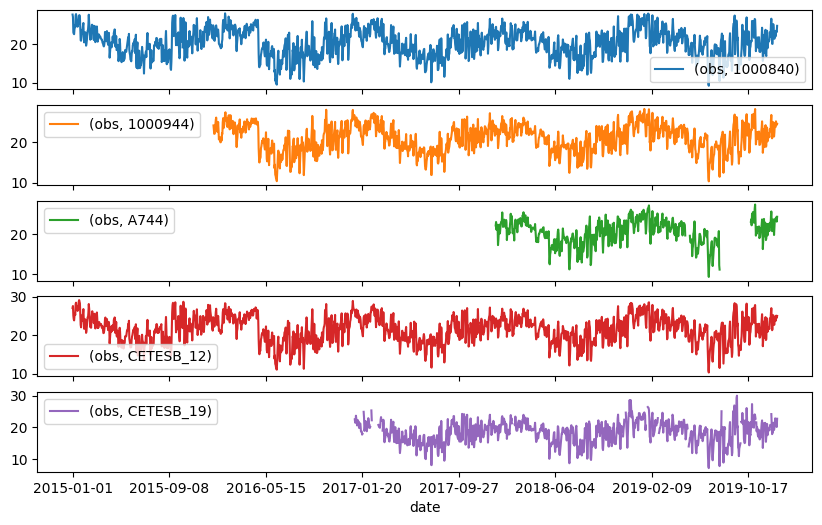

In [ ]:
#TIME SERIES OF OBSERVATIONS BY STATION
pd.pivot_table(validation.reset_index(),
               index='date', columns='station', values=['obs']
              ).plot(subplots=True, layout=(5,1),figsize=(10,6))
plt.savefig(os.path.join('Figures/test_obs_ts_'+model+'.png'), bbox_inches = "tight")
plt.show()

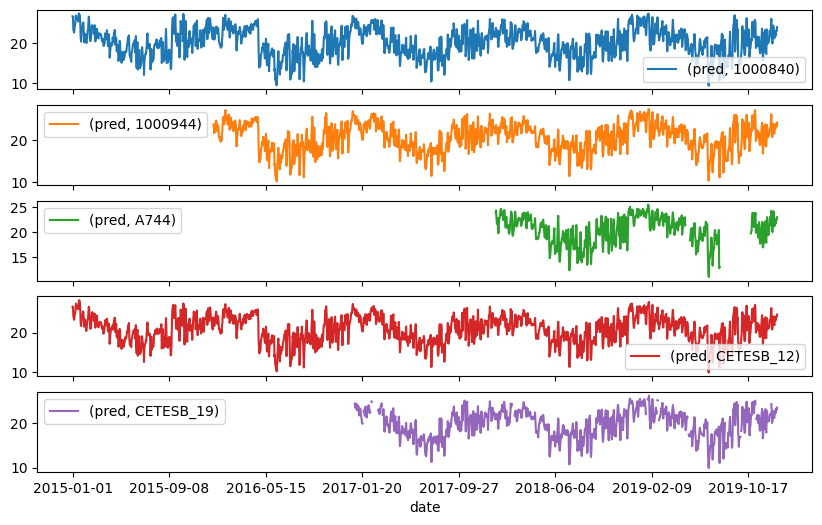

In [ ]:
#Predictions
pd.pivot_table(validation.reset_index(),
               index='date', columns='station', values=['pred']
              ).plot(subplots=True, layout=(5,1),figsize=(10,6))
plt.savefig(os.path.join('Data/figures/test_pred_'+model+'.png'), bbox_inches = "tight")
plt.show()

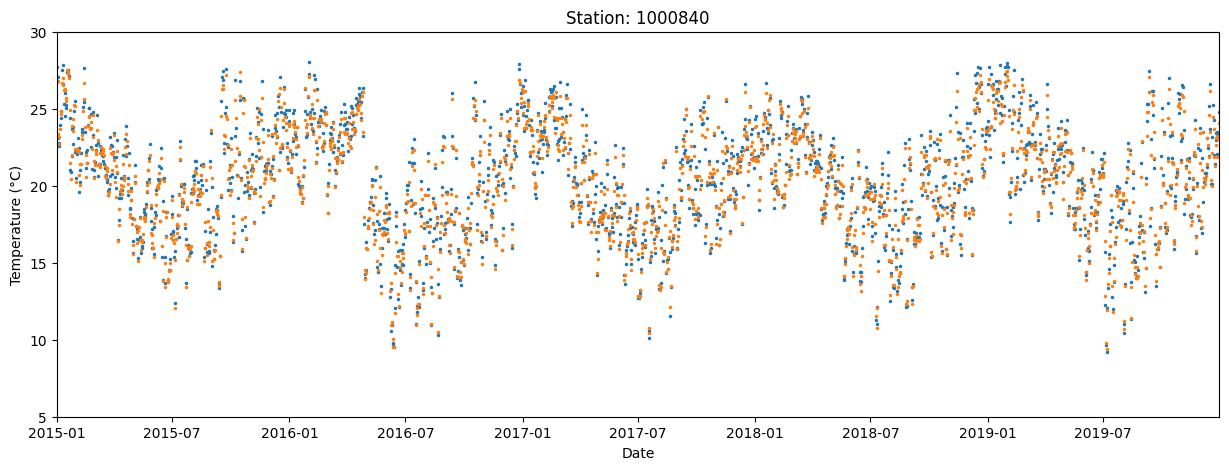

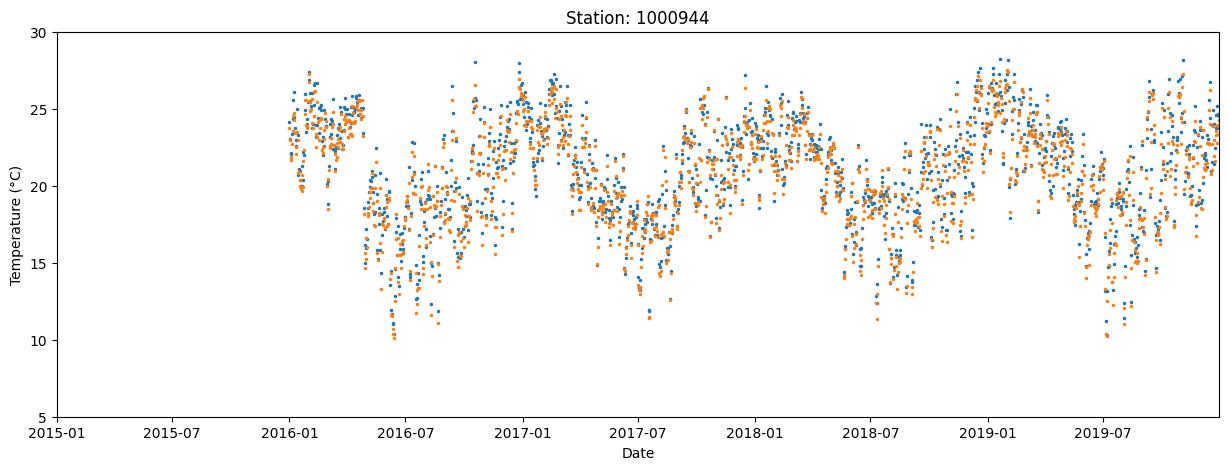

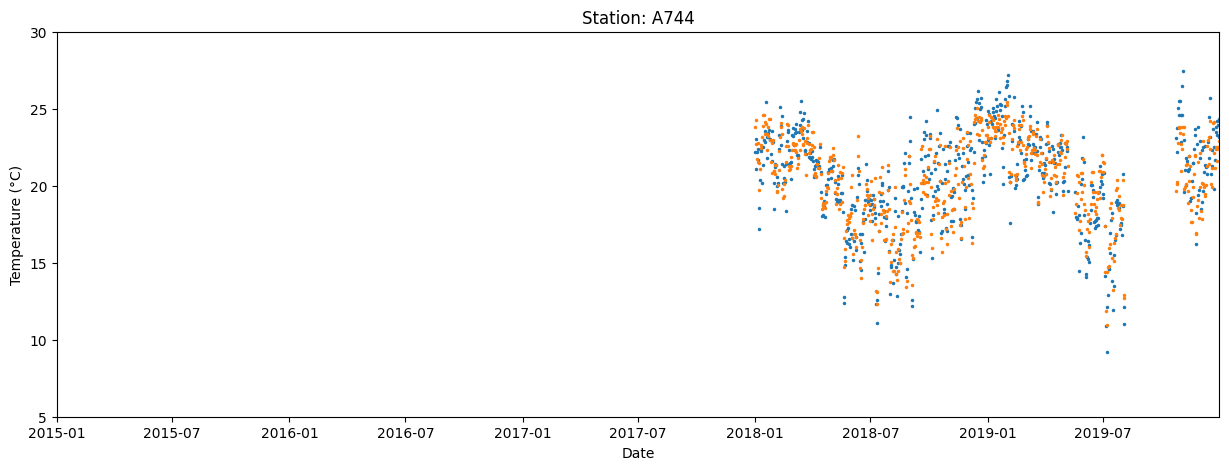

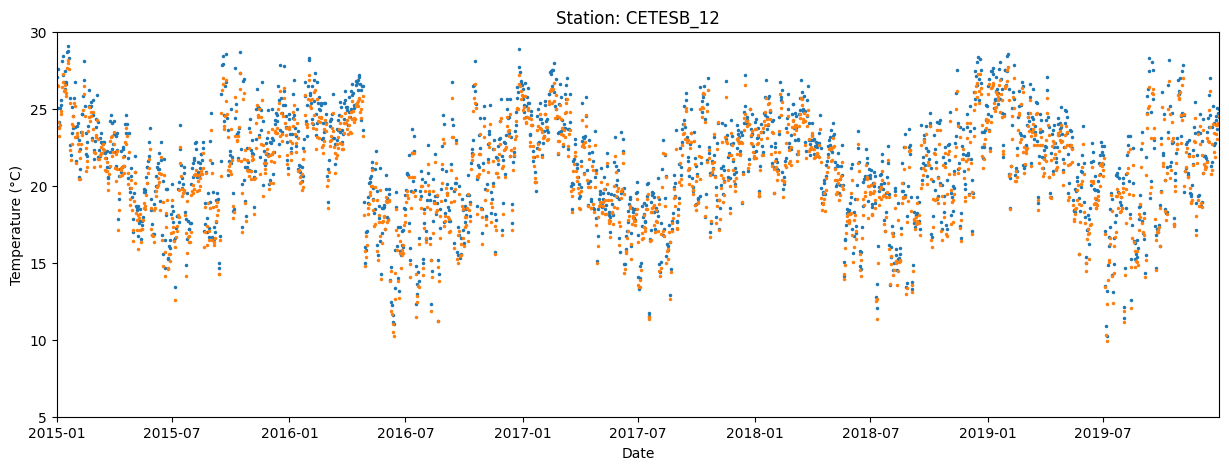

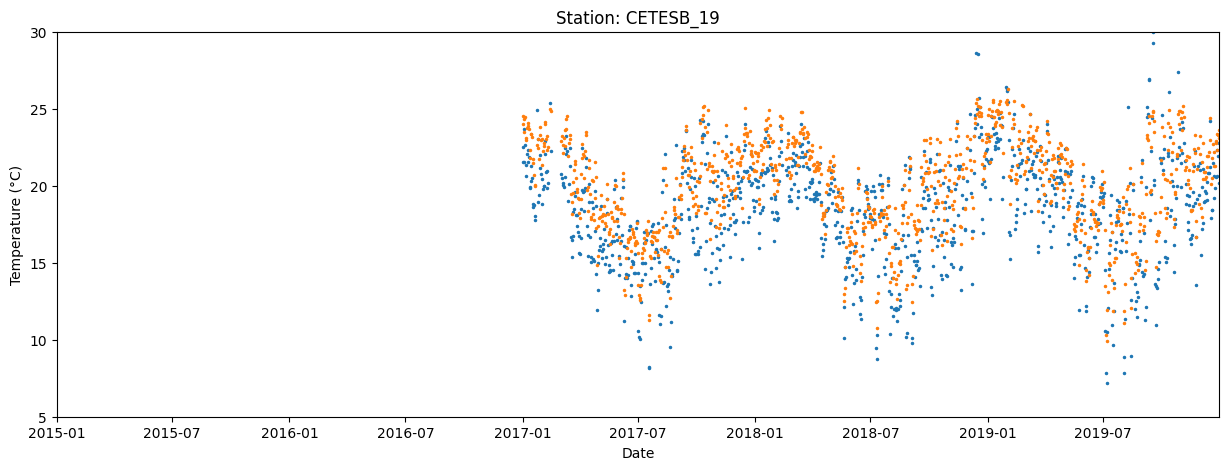

In [ ]:
#TIME SERIES OBS + PRED BY STATION
for i in stations:
  plt.subplots(figsize=(15,5))
  plt.plot_date(pd.to_datetime(validation[validation['station']==i]['date']), validation[validation['station']==i]['obs'], color='C0', markersize=1.5) #blue
  plt.xlim(dt.date(2015,1,1),dt.date(2019,12,31))
  plt.ylim(5,30)
  plt.plot_date(pd.to_datetime(validation[validation['station']==i]['date']), validation[validation['station']==i]['pred'],  color='C1', markersize=1.5) #orange
  plt.xlim(dt.date(2015,1,1),dt.date(2019,12,31))
  plt.ylim(5,30)
  plt.xlabel('Date')# Set x-axis label
  plt.ylabel('Temperature (°C)')# Set y-axis label
  plt.title(f'Station: {i}')
  plt.savefig(os.path.join('Figures/test_pred'+f'Station: {i}'+'_'+model+'.png'), bbox_inches = "tight")
  plt.show()

1000840


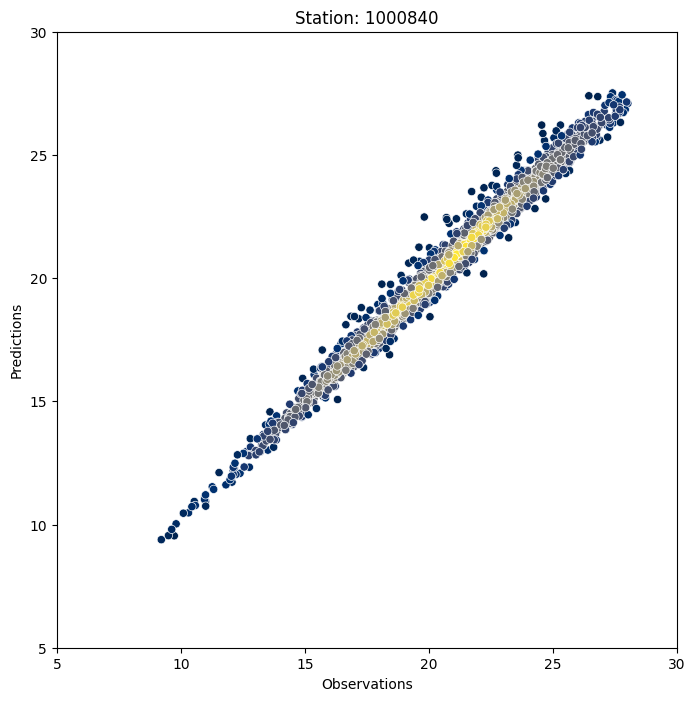

1000944


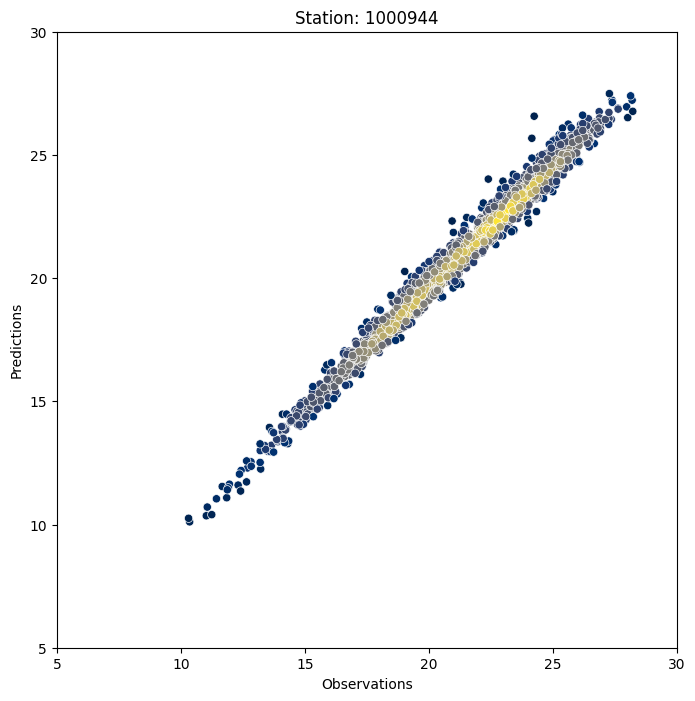

A744


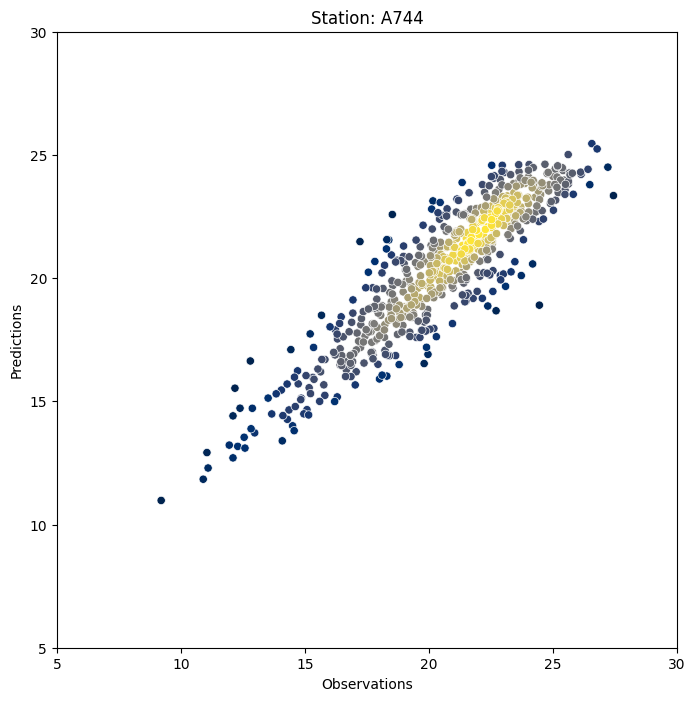

CETESB_12


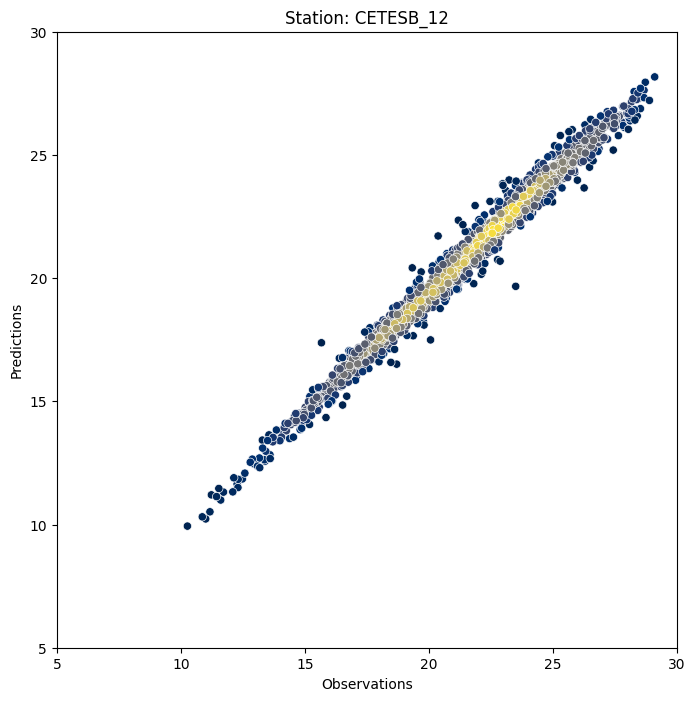

CETESB_19


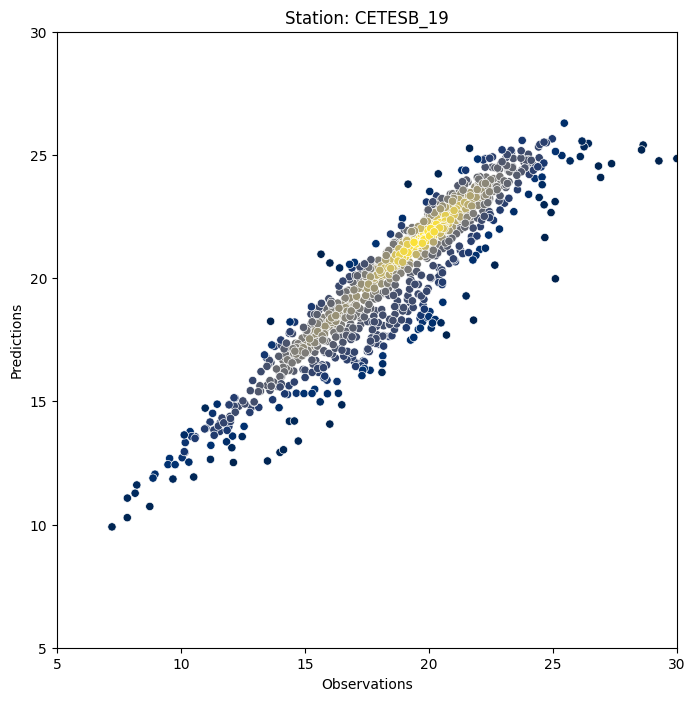

In [ ]:
#CORRLATION PLOTS OBS + PRED BY STATION
from scipy import stats
for i in stations:
  print(i)
  values = np.vstack([validation[validation['station']==i]["pred"], validation[validation['station']==i]["obs"]])
  kernel = stats.gaussian_kde(values)(values)
  fig, ax=plt.subplots(figsize=(8,8))
  sns.scatterplot(
      data=validation[validation['station']==i],
      x='obs',
      y='pred',
      c=kernel,
      cmap="cividis",
      ax=ax,
  )
  ax.set_xlim(5, 30)
  ax.set_ylim(5, 30)
  plt.title(f'Station: {i}')
  plt.xlabel('Observations')# Set x-axis label
  plt.ylabel('Predictions')# Set y-axis label
  plt.savefig('/content/gdrive/MyDrive/Temp_modelling/data/figures/test_corr_'+f'Station: {i}'+'_'+model+'.png', bbox_inches = "tight")
  plt.show()

## 10.5. Accuracy indicators

In [ ]:
#OVERALL
from sklearn import metrics
#Estimate performance:
mae=[metrics.mean_absolute_error(obs_val_degr, pred_val_degr)]
mse=[metrics.mean_squared_error(obs_val_degr, pred_val_degr)]
rmse= [np.sqrt(metrics.mean_squared_error(obs_val_degr, pred_val_degr))]
rsq=[metrics.r2_score(obs_val_degr, pred_val_degr)]

#Print performance metrics:
print('Mean Absolute Error:', mae)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:',rmse)
print('R-square:',rsq)

#Export
export=pd.DataFrame({'MAE':mae, 'RMSE': rmse, 'MSE': mse, 'r2': rsq})
export.to_csv('/content/gdrive/MyDrive/Temp_modelling/data/tables/test_metrics_'+model+'.csv')#Export dataset

Mean Absolute Error: [0.752624971160135]
Mean Squared Error: [1.0587223596423336]
Root Mean Squared Error: [1.028942350009141]
R-square: [0.9152510451512482]


In [ ]:
#BY STATION
for i in stations:
  print(i)
  #Estimate performance:
  mae=[metrics.mean_absolute_error( validation[validation['station']==i]["obs"], validation[validation['station']==i]["pred"])]
  mse=[metrics.mean_squared_error( validation[validation['station']==i]["obs"], validation[validation['station']==i]["pred"])]
  rmse= [np.sqrt(metrics.mean_squared_error( validation[validation['station']==i]["obs"], validation[validation['station']==i]["pred"]))]
  rsq=[metrics.r2_score( validation[validation['station']==i]["obs"], validation[validation['station']==i]["pred"])]

  #Print performance metrics:
  print('Mean Absolute Error:', mae)
  print('Mean Squared Error:', mse)
  print('Root Mean Squared Error:',rmse)
  print('R-square:',rsq)

  #Export
  export=pd.DataFrame({'MAE':mae, 'RMSE': rmse, 'MSE': mse, 'r2': rsq})
  export.to_csv('/content/gdrive/MyDrive/Temp_modelling/data/tables/test_metrics_'+f'Station: {i}'+'_'+model+'.csv')#Export dataset

1000840
Mean Absolute Error: [0.38075497350839016]
Mean Squared Error: [0.24493966706462708]
Root Mean Squared Error: [0.49491379760987375]
R-square: [0.9804928934299167]
1000944
Mean Absolute Error: [0.47932359176187134]
Mean Squared Error: [0.3328481344276771]
Root Mean Squared Error: [0.5769299215915891]
R-square: [0.970138253945252]
A744
Mean Absolute Error: [1.011265200424278]
Mean Squared Error: [1.712454763885142]
Root Mean Squared Error: [1.3086079488850517]
R-square: [0.8174808320688872]
CETESB_12
Mean Absolute Error: [0.6905466666925651]
Mean Squared Error: [0.6419785128759489]
Root Mean Squared Error: [0.801235616330146]
R-square: [0.9443474133521106]
CETESB_19
Mean Absolute Error: [1.7303829010701837]
Mean Squared Error: [3.811897890800212]
Root Mean Squared Error: [1.9524082285219482]
R-square: [0.6735626261981993]


# 11.Predictions

## 11.1. Load trained model

In [ ]:
#Instead of 'today' we may need to add the specific date
#define date to serach for model
#date = datetime.now().strftime("%d-%m-%Y-%H:%M")
date=today
rf_model=glob(''.join(('Data/RF-'+date+'_'+model+'.pkl')))
#rf_model=glob(''.join(('Data/RF-04-05-2023-14:27.pkl')))

if rf_model == []:
        print('No file with such pattern was found in the directory. Run TRAINING = True first.')
else:
  with open(rf_model[0],'rb') as f:
    regressor = pickle.load(f)
rf_model=regressor
print('Importing model run on ', date, 'with parameters: ', rf_model)

Importing model run on  08-05-2023-15:37 with parameters:  RandomForestRegressor(max_depth=15, max_features='sqrt', max_samples=0.2,
                      min_samples_leaf=2, n_estimators=1000)


## 11.2. Define directories

In [ ]:
#DEFINE INPUT FOLDERS
# [!] Before running, this folder should contain the daily excel files witht he predictor variables in it.
in_folder=os.path.join('Newdata/')


In [ ]:
#CREATE FOLDER TO SAVE OUTPUTS WITH TODAYS DATE
date_export=today
os.makedirs(os.path.join('Predictions/'+date_export+'_'+model))
out_folder=os.path.join('Predictions/'+date_export+'_'+model)

## 11.3. Define parameters for prediction

In [ ]:
#CHECK FEATURES TO USE
print('Selected variables: ', sel_varsPredict)

Selected variables:  ['sza', 'lst', 'rh', 'd2m', 't2m', 'v10', 'u10', 'daylength']


In [ ]:
#DEFINE DATE RANGE
start = dt.datetime.strptime("2018-01-01", "%Y-%m-%d")
end = dt.datetime.strptime("2018-12-31", "%Y-%m-%d")
dates= pd.date_range(start, end).strftime("%Y-%m-%d")
dates

Index(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
       '2018-01-06', '2018-01-07', '2018-01-08', '2018-01-09', '2018-01-10',
       ...
       '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25', '2018-12-26',
       '2018-12-27', '2018-12-28', '2018-12-29', '2018-12-30', '2018-12-31'],
      dtype='object', length=365)

In [ ]:
#DEFINE TYPE OF ALGORITHM
algorithm='RF' #Random forest

## 11.4. Predict temperature

In [ ]:
#RUN CODE FOR PREDICTIONS
## It loops over each day and create a day-specific .csv export
for i in dates:
  print('Processing day:',i)

  print('[1/10] Uploading data...')
  newdata=pd.read_csv(in_folder+ '/newdata_'+ i+'.csv')#The data was generated by the file '01_DataPreparation.ipynb'

  print('[2/10] Selecting features & converting to np.array...')
  newdatanp=newdata[sel_varsPredict].to_numpy()

  print('[3/10] Checking shape...')
  print('Shape array: ', newdatanp.shape)

  print('[4/10] Normalizing data...')
  if algorithm=='RF':
    newdata_norm=newdatanp
  else:
    new_scaler=MinMaxScaler()
    newdata_norm=new_scaler.fit_transform(newdatanp)
  print('Shape normalized array: ', newdata_norm.shape)

  print('[5/10] Obtaining predictions... ')
  pred_newdata=rf_model.predict(newdata_norm)
  print('Shape predictions array: ', pred_newdata.shape)

  print('[6/10] Reverting predictions...')
  if algorithm=='RF':
    print('Not needed since we run a RF')
    pred_newdata_revnorm=pred_newdata
  else:
    pred_newdata_revnorm=scaler.inverse_transform(pred_newdata.reshape(-1,1))

  print('[7/10] Confirming shape...')
  print('Shape of predictions:', pred_newdata_revnorm.shape)

  print('[8/10] Confirming units predictions...')
  print('Predictions example data point:', pred_newdata_revnorm[[1]])

  print('[9/10] Creating pd dataframe...')
  output=pd.DataFrame({'x':newdata['x'],'y':newdata['y'] ,'pred':pred_newdata_revnorm})
  print(output.head())

  print('[10/10] Exporting output...')
  output.to_csv(out_folder + '/output_'+ i+'.csv')

Streaming output truncated to the last 5000 lines.
Predictions example data point: [15.33261157]
[9/10] Creating pd dataframe...
               x             y       pred
0  350201.135406  7.424276e+06  15.333196
1  350701.135406  7.424276e+06  15.332612
2  351201.135406  7.424276e+06  15.325525
3  351701.135406  7.424276e+06  15.325211
4  352201.135406  7.424276e+06  15.348781
[10/10] Exporting output...
Processing day: 2018-05-29
[1/10] Uploading data...
[2/10] Selecting features & converting to np.array...
[3/10] Checking shape...
Shape array:  (24854, 8)
[4/10] Normalizing data...
Shape normalized array:  (24854, 8)
[5/10] Obtaining predictions... 
Shape predictions array:  (24854,)
[6/10] Reverting predictions...
Not needed since we run a RF
[7/10] Confirming shape...
Shape of predictions: (24854,)
[8/10] Confirming units predictions...
Predictions example data point: [14.95043708]
[9/10] Creating pd dataframe...
               x             y       pred
0  350201.135406  7.424276

---
END OF FILE

---

